In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Esercitazione 7

Esercizio 7.2 è su data blocking e autocorrelazione, Esercizio 7.4 è sulla gofr. Per ogni stato ho fatto entrambi gli esercizi. Nel primo faccio prima giro con tot passi (tipo 6000), controllo accettazione fissando il delta per averla del 50% e poi rifaccio equilibrazione (600 sol e liq, 1000 gas) più 5*1e5 passi con la delta giusta. Lo stesso valore fissato poi lo uso per le simulazioni della parte sulla gofr. Attenzione:equilibrazione con dinamica molecolare è diversa!

In [76]:
#in generale mi pare che le cose tornino, c'è da capire però come fare il calcolo della pressione (come in Es4) e da capire come fare un grafico che confronti le gofr con i due metodi (tipo boh plottare la differenza fra i valori ottenuti con un metodo e l'altro o boh)

In [6]:
#implementazione del calcolo della funzione di autocorrelazione dato un array di misure mis e un tempo t
def AutoCorr(mis, t):
    t_max=len(mis)
    #sommatorie della formula nell'ordine in cui compaiono, con già la normalizzazione
    sum1=np.mean(mis[:t_max-t]*mis[t:t_max])
    sum2=np.mean(mis[:(t_max-t)])
    sum3=np.mean(mis[t:t_max])
    sum4=np.mean(mis*mis)
    sum5=np.mean(mis)
    return (sum1-(sum2*sum3))/(sum4-(sum5**2))

#errore a blocchi larghi L passi su un array di dati mis, ritorna media e errore all'ultimo blocco
def BlockAnalysis(mis, L):
    if L==0:
        raise ValueError("Errore: la larghezza dei blocchi non può essere zero.")
    B=len(mis)//L  #numero di blocchi
    if len(mis)%B != 0:
        raise ValueError("Attenzione: il numero di blocchi inserito non è divisore del numero di lanci totale.")
    mis_blocks=np.reshape(mis[:B*L], (B, L))  #creo B vettori da L elementi
    #medie per ogni blocco
    mean_block=np.mean(mis_blocks, axis=1)
    mean_block2=mean_block*mean_block
    #medie considerando tutti i blocchi
    mean_tot=np.sum(mean_block)/B
    mean_tot2=np.sum(mean_block2)/B
    #errore all'ultimo blocco
    fin_error=np.sqrt((mean_tot2 - mean_tot**2)/B)
    return fin_error   

In [36]:
#variabili utilizzate

Neq=600  #passi della simulazione di equilibrazione
xeq=np.arange(Neq)  #plotto in base agli steps, non faccio media a blocchi
gNeq=1000  #passi della simulazione di equilibrazione del gas (ha bisogno di più tempo)
gxeq=np.arange(gNeq)
Nan=500000  #passi della simulazione di analisi
xan=np.arange(Nan)  #plotto in base agli steps, non faccio media a blocchi
Ls=np.array([x for x in range(10,5001) if (Nan%x ==0)]) #divisori di 500000 che uso come larghezza dei blocchi
ts=xan[:800]  #valori di t per cui valuto autocorrelazione di solidi e liquidi
gts=xan[:10000]  #t autocorrelazione gas

Nbl=50  #numero blocchi analisi gofr
xbl=np.arange(Nbl)+1

# Stato solido 

## Data blocking e autocorrelazione 

In [78]:
sol_inst=np.loadtxt("SolidState/inst_penergy.dat", delimiter=" ", usecols=0,  unpack="true")  #vettore delle ordinate dei punti plottati

In [79]:
sol_ac=np.empty(len(ts))
for i in range(len(ts)):
    sol_ac[i]=AutoCorr(sol_inst, ts[i])

In [80]:
sol_error=np.zeros(len(Ls))
for i in range(len(Ls)):
    sol_error[i]=BlockAnalysis(sol_inst, Ls[i])

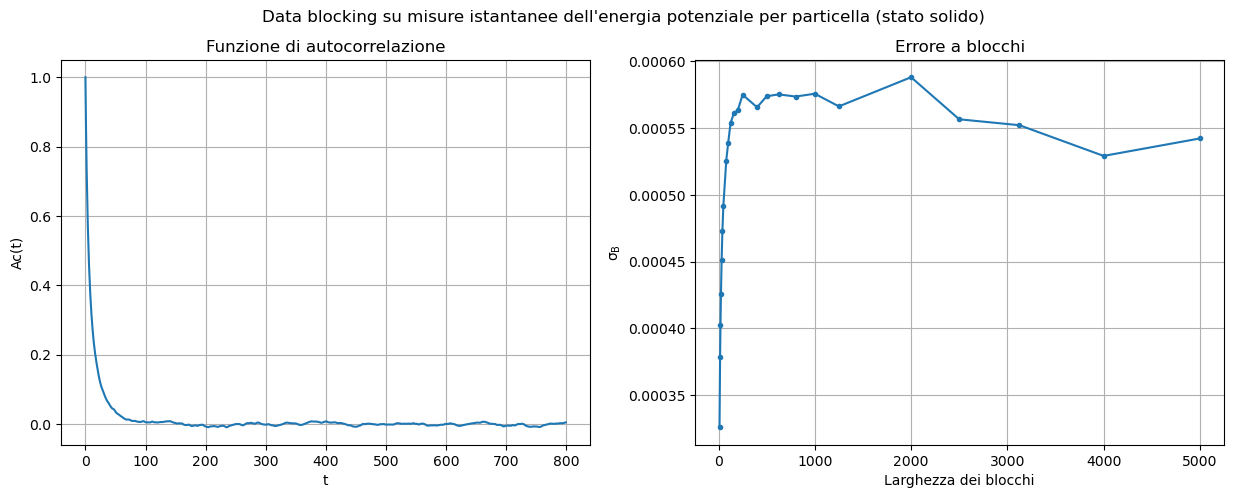

In [81]:
sbfig ,(sbplt1, sbplt2) = plt.subplots(1, 2, figsize=(15, 5))

sbplt1.plot(ts, sol_ac)
sbplt1.set_xlabel("t")
sbplt1.set_ylabel("Ac(t)")
sbplt1.set_title("Funzione di autocorrelazione")
sbplt1.grid(True)

sbplt2.plot(Ls, sol_error, marker='.')
sbplt2.set_xlabel("Larghezza dei blocchi")
sbplt2.set_ylabel(r"$\mathrm{\sigma_B}$")
sbplt2.set_title("Errore a blocchi")
sbplt2.grid(True)

sbfig.suptitle("Data blocking su misure istantanee dell'energia potenziale per particella (stato solido)")
plt.show()

In [27]:
#L'errore a blocchi dovrebbe stabilizzarsi (vero?), non capisco perchè non lo fa, ho anche provato a usare la funzione definita dal prof nella Es1 e resta così l'andamento

## Gofr

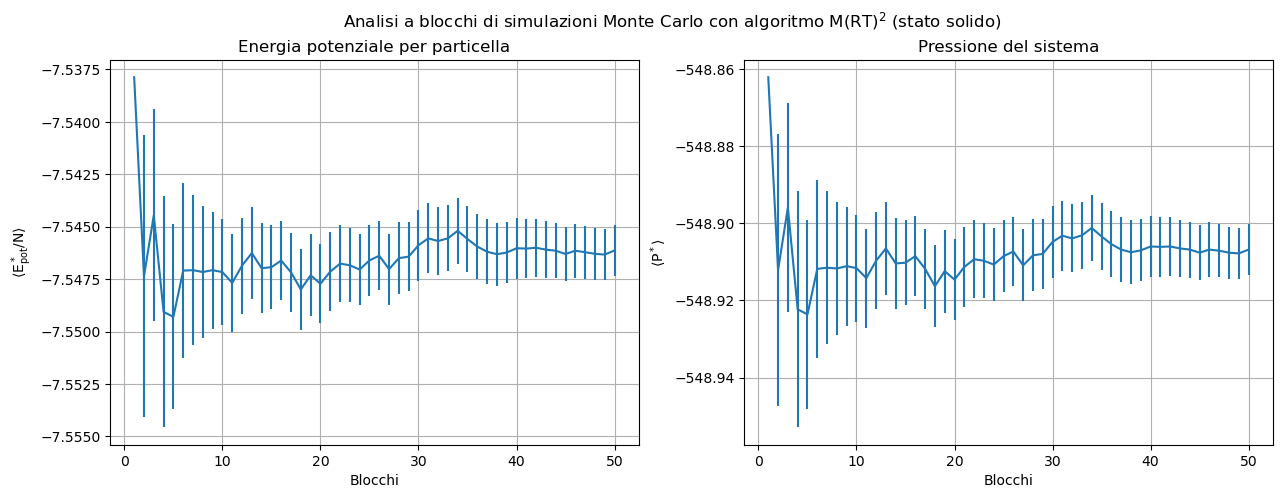

In [82]:
#simulazione Monte Carlo (passi con Metropolis) di energia potenziale e pressione
sol_en, sol_en_err=np.loadtxt("SolidState/potential_energy.dat", usecols=(2, 3), unpack="true")  #vettore delle ordinate dei punti plottati
sol_pres, sol_pres_err=np.loadtxt("SolidState/pressure.dat", usecols=(2, 3), unpack="true")

smfig ,(smplt1, smplt2) = plt.subplots(1, 2, figsize=(15, 5))

smplt1.errorbar(xbl, sol_en, yerr=sol_en_err)
smplt1.set_xlabel("Blocchi")
smplt1.set_ylabel(r"$\langle \mathrm{E_{pot}^*/N} \rangle$")
smplt1.set_title("Energia potenziale per particella")
smplt1.grid(True)

smplt2.errorbar(xbl, sol_pres, yerr=sol_pres_err)
smplt2.set_xlabel("Blocchi")
smplt2.set_ylabel(r"$\langle \mathrm{P^*} \rangle$")
smplt2.set_title("Pressione del sistema")
smplt2.grid(True)

smfig.suptitle(r"Analisi a blocchi di simulazioni Monte Carlo con algoritmo $\mathrm{M(RT)^2}$ (stato solido)")
plt.show()

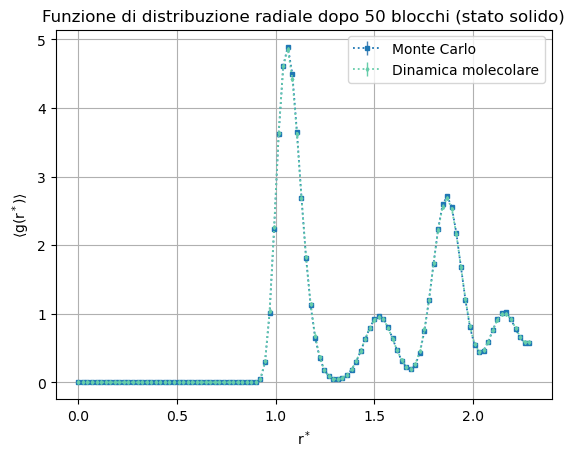

In [83]:
#simulazione della gofr con moltecarlo e con dinamica molecolare
sol_xgofr1, sol_gofr1, sol_err1=np.loadtxt("SolidState/fin_gofr1.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Monte Carlo
sol_xgofr0, sol_gofr0, sol_err0=np.loadtxt("SolidState/fin_gofr0.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Dinamica Molecolare

plt.errorbar(sol_xgofr1, sol_gofr1, yerr=sol_err1, marker='s', linestyle=':', elinewidth=1, ecolor="steelblue", markersize=2.5, linewidth=1.3, label="Monte Carlo")
plt.errorbar(sol_xgofr0, sol_gofr0, yerr=sol_err0, marker='d', linestyle=':', elinewidth=1, markersize=2, linewidth=1.3, label="Dinamica molecolare", color="mediumaquamarine")
plt.xlabel(r"$\mathrm{r^*}$")
plt.ylabel(r"$\langle \mathrm{g(r^*)} \rangle$")
plt.grid(True)
plt.legend()
plt.title("Funzione di distribuzione radiale dopo 50 blocchi (stato solido)")

plt.show()

# Stato liquido

## Data blocking e autocorrelazione 

In [84]:
liq_inst=np.loadtxt("LiquidState/inst_penergy.dat", delimiter=" ", usecols=0,  unpack="true")  #vettore delle ordinate dei punti plottati

In [85]:
liq_ac=np.empty(len(ts))
for i in range(len(ts)):
    liq_ac[i]=AutoCorr(liq_inst, ts[i])

In [86]:
liq_error=np.zeros(len(Ls))
for i in range(len(Ls)):
    liq_error[i]=BlockAnalysis(liq_inst, Ls[i])

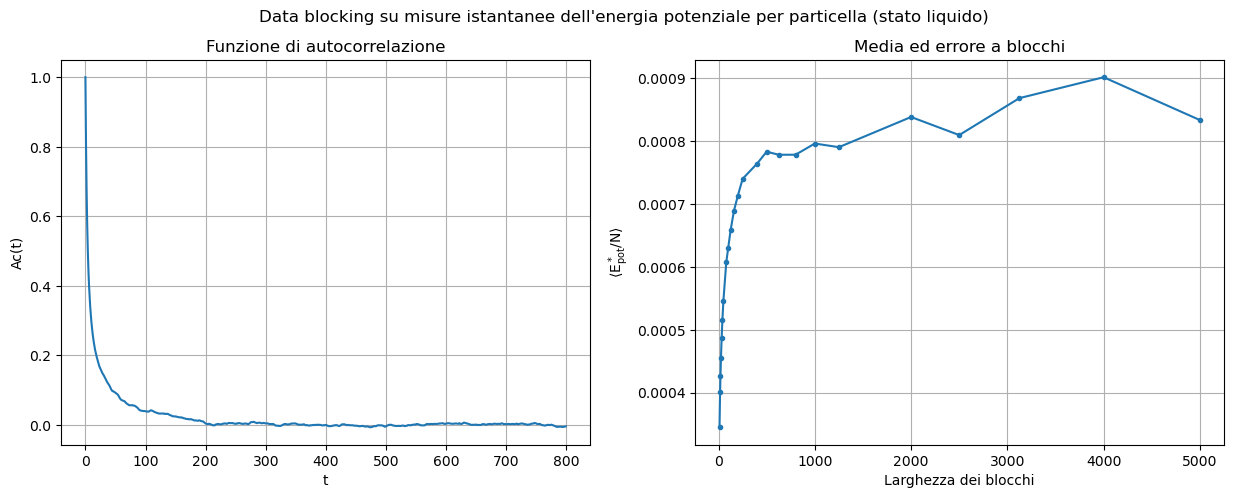

In [87]:
lbfig ,(lbplt1, lbplt2) = plt.subplots(1, 2, figsize=(15, 5))

lbplt1.plot(ts, liq_ac)
lbplt1.set_xlabel("t")
lbplt1.set_ylabel("Ac(t)")
lbplt1.set_title("Funzione di autocorrelazione")
lbplt1.grid(True)

lbplt2.plot(Ls, liq_error, marker='.')
lbplt2.set_xlabel("Larghezza dei blocchi")
lbplt2.set_ylabel(r"$\langle \mathrm{E_{pot}^*/N} \rangle$")
lbplt2.set_title("Media ed errore a blocchi")
lbplt2.grid(True)

lbfig.suptitle("Data blocking su misure istantanee dell'energia potenziale per particella (stato liquido)")
plt.show()

## Gofr

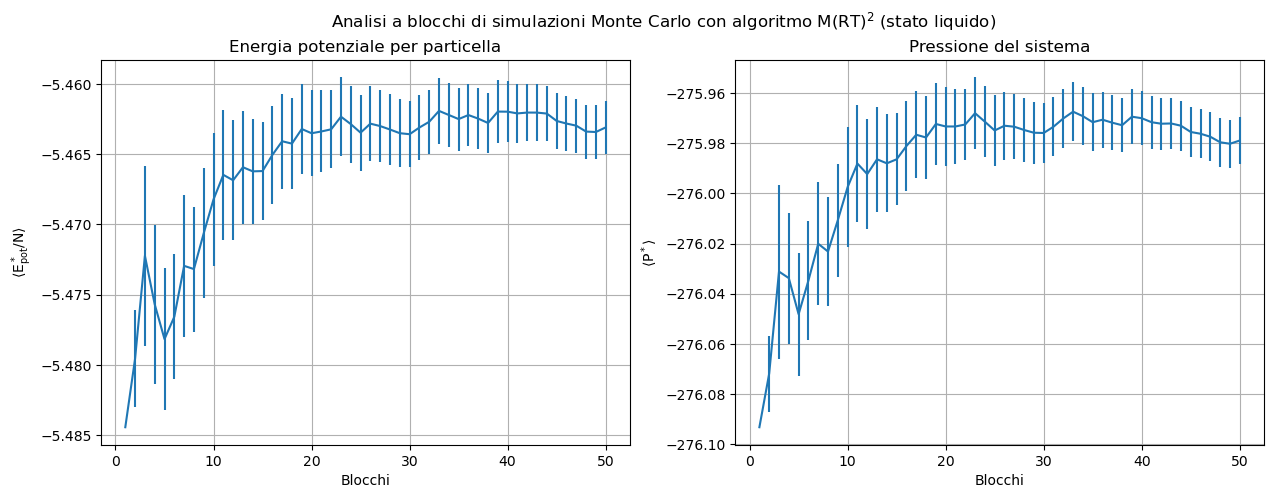

In [88]:
#simulazione Monte Carlo (passi con Metropolis) di energia potenziale e pressione
liq_en, liq_en_err=np.loadtxt("LiquidState/potential_energy.dat", usecols=(2, 3), unpack="true")  #vettore delle ordinate dei punti plottati
liq_pres, liq_pres_err=np.loadtxt("LiquidState/pressure.dat", usecols=(2, 3), unpack="true")

lmfig ,(lmplt1, lmplt2) = plt.subplots(1, 2, figsize=(15, 5))

lmplt1.errorbar(xbl, liq_en, yerr=liq_en_err)
lmplt1.set_xlabel("Blocchi")
lmplt1.set_ylabel(r"$\langle \mathrm{E_{pot}^*/N} \rangle$")
lmplt1.set_title("Energia potenziale per particella")
lmplt1.grid(True)

lmplt2.errorbar(xbl, liq_pres, yerr=liq_pres_err)
lmplt2.set_xlabel("Blocchi")
lmplt2.set_ylabel(r"$\langle \mathrm{P^*} \rangle$")
lmplt2.set_title("Pressione del sistema")
lmplt2.grid(True)

lmfig.suptitle(r"Analisi a blocchi di simulazioni Monte Carlo con algoritmo $\mathrm{M(RT)^2}$ (stato liquido)")
plt.show()

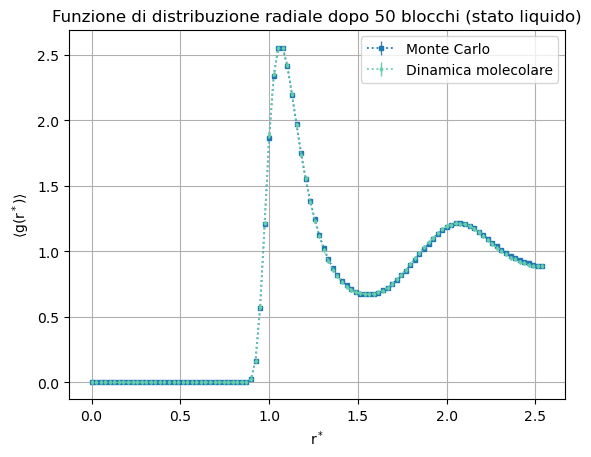

In [89]:
#simulazione della gofr con moltecarlo e con dinamica molecolare
liq_xgofr1, liq_gofr1, liq_err1=np.loadtxt("LiquidState/fin_gofr1.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Monte Carlo
liq_xgofr0, liq_gofr0, liq_err0=np.loadtxt("LiquidState/fin_gofr0.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Dinamica Molecolare

plt.errorbar(liq_xgofr1, liq_gofr1, yerr=liq_err1, marker='s', elinewidth=1, ecolor="steelblue", linestyle=':', markersize=2.5, linewidth=1.3, label="Monte Carlo")
plt.errorbar(liq_xgofr0, liq_gofr0, yerr=liq_err0, marker='d', elinewidth=1, markersize=2, linestyle=':', linewidth=1.3, label="Dinamica molecolare", color="mediumaquamarine")
plt.xlabel(r"$\mathrm{r^*}$")
plt.ylabel(r"$\langle \mathrm{g(r^*)} \rangle$")
plt.grid(True)
plt.legend()
plt.title("Funzione di distribuzione radiale dopo 50 blocchi (stato liquido)")

plt.show()

# Stato gassoso

## Data blocking e autocorrelazione

In [1]:
#Non riesco a far scendere l'accettazione sotto a 0.6, ho usato delta tc alpha=0.62

In [8]:
gas_eq=np.loadtxt("GasState/eq_penergy.dat", delimiter=" ", usecols=0,  unpack="true")  #vettore delle ordinate dei punti plottati
gas_inst=np.loadtxt("GasState/inst_penergy.dat", delimiter=" ", usecols=0,  unpack="true")  #vettore delle ordinate dei punti plottati

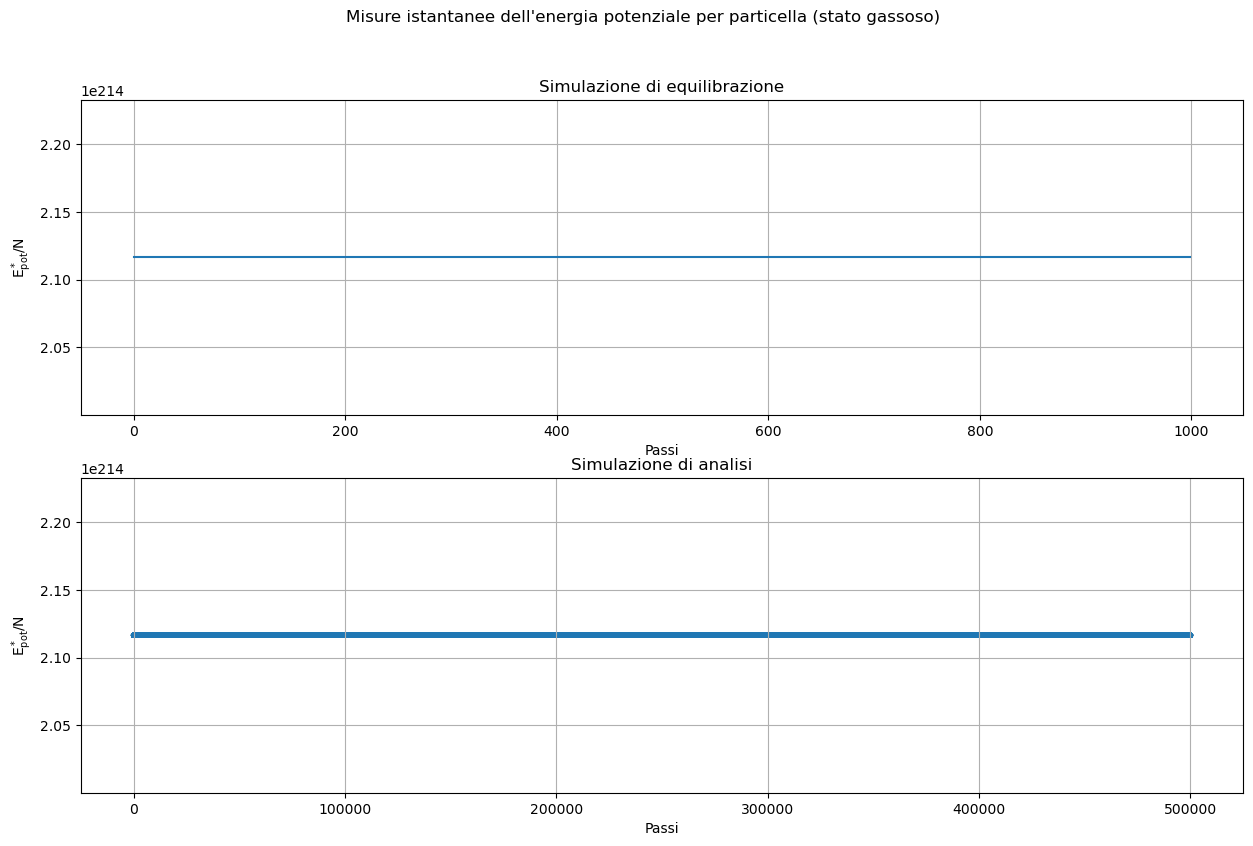

In [9]:
gfig ,(gplt1, gplt2) = plt.subplots(2, 1, figsize=(15, 9))

gplt1.plot(gxeq, gas_eq)
gplt1.set_xlabel("Passi")
gplt1.set_ylabel(r"$\mathrm{E_{pot}^*/N}$")
gplt1.set_title("Simulazione di equilibrazione")
gplt1.grid(True)

gplt2.scatter(xan, gas_inst, marker='.', linestyle='', alpha=0.2)
gplt2.set_xlabel("Passi")
gplt2.set_ylabel(r"$\mathrm{E_{pot}^*/N}$")
gplt2.set_title("Simulazione di analisi")
gplt2.grid(True)

gfig.suptitle("Misure istantanee dell'energia potenziale per particella (stato gassoso)")
plt.show()

In [17]:
gas_ac=np.empty(len(gts))
for i in range(len(gts)):
    gas_ac[i]=AutoCorr(gas_inst, gts[i])

In [18]:
gas_error=np.zeros(len(Ls))
for i in range(len(Ls)):
    gas_error[i]=BlockAnalysis(gas_inst, Ls[i])

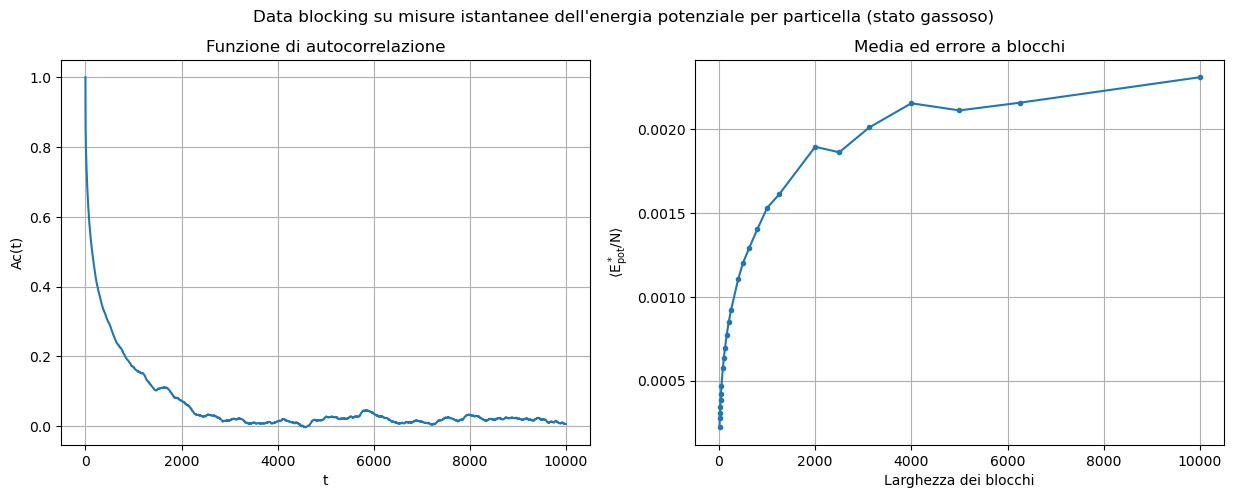

In [19]:
gbfig ,(gbplt1, gbplt2) = plt.subplots(1, 2, figsize=(15, 5))

gbplt1.plot(gts, gas_ac)
gbplt1.set_xlabel("t")
gbplt1.set_ylabel("Ac(t)")
gbplt1.set_title("Funzione di autocorrelazione")
gbplt1.grid(True)

gbplt2.plot(Ls, gas_error, marker='.')
gbplt2.set_xlabel("Larghezza dei blocchi")
gbplt2.set_ylabel(r"$\langle \mathrm{E_{pot}^*/N} \rangle$")
gbplt2.set_title("Media ed errore a blocchi")
gbplt2.grid(True)

gbfig.suptitle("Data blocking su misure istantanee dell'energia potenziale per particella (stato gassoso)")
plt.show()

Non mi convincono molto questi grafici sinceramente

## Gofr

In [ ]:
#simulazione Monte Carlo (passi con Metropolis) di energia potenziale e pressione
gas_en, gas_en_err=np.loadtxt("GasState/potential_energy.dat", usecols=(2, 3), unpack="true")  #vettore delle ordinate dei punti plottati
gas_pres, gas_pres_err=np.loadtxt("GasState/pressure.dat", usecols=(2, 3), unpack="true")

gmfig ,(gmplt1, gmplt2) = plt.subplots(1, 2, figsize=(15, 5))

gmplt1.errorbar(xbl, gas_en, yerr=gas_en_err)
gmplt1.set_xlabel("Blocchi")
gmplt1.set_ylabel(r"\langle \mathrm{E_{pot}^*/N} \rangle")
gmplt1.set_title("Energia potenziale per particella")
gmplt1.grid(True)

gmplt2.errorbar(xbl, gas_pres, yerr=gas_pres_err)
gmplt2.set_xlabel("Blocchi")
gmplt2.set_ylabel(r"\langle \mathrm{P^*} \rangle")
gmplt2.set_title("Pressione del sistema")
gmplt2.grid(True)

gmfig.suptitle(r"Analisi a blocchi di simulazioni Monte Carlo con algoritmo $\mathrm{M(RT)^2}$ (stato liquido)")
plt.show()

In [ ]:
#simulazione della gofr con moltecarlo e con dinamica molecolare
gas_xgofr1, gas_gofr1, gas_err1=np.loadtxt("GasState/fin_gofr1.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Monte Carlo
gas_xgofr0, gas_gofr0, gas_err0=np.loadtxt("GasState/fin_gofr0.dat", usecols=(0, 1, 2), unpack="true")  #x, y e yerr plot gofr Dinamica Molecolare

plt.errorbar(gas_xgofr1, gas_gofr1, yerr=gas_err1, marker='s', elinewidth=1, ecolor="steelblue", markersize=2.2, linewidth=0.8, label="Monte Carlo")
plt.errorbar(gas_xgofr0, gas_gofr0, yerr=gas_err0, marker='d', elinewidth=1, markersize=2.2, linewidth=0.8, label="Dinamica molecolare", color="mediumaquamarine")
plt.xlabel(r"$\mathrm{r^*}$")
plt.ylabel(r"$\langle \mathrm{g(r^*)} \rangle$")
plt.grid(True)
plt.legend()
plt.title("Funzione di distribuzione radiale dopo 50 blocchi (stato liquido)")

plt.show()